<a href="https://colab.research.google.com/github/j3rsey/project/blob/main/AI_04_%EA%B3%BD%EC%83%81%ED%98%81_Project1_wine_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nltk

In [ ]:
pip install pycorenlp

In [ ]:
pip install stanza

In [ ]:
pip install surprise

     |████████████████████████████████| 11.8 MB 4.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619424 sha256=37db3895378be7c986daaebaaea55fd49e493b96d3ff90da03f9155376473dfd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# Wine recommend project 

|**Colmun**|**Description**|
|-|-|
|country | 와인 원산지 국가|
|description | 소믈리에 들이 남긴 리뷰|
|designation | 와인 제작에 사용된 포도가 있는 winery 안의 포도원(와인제작을 위해 재배되는 포도농장) |
|points | WineEnthusiast에서 1-100사이의 척도로 와인을 평가한 점수|
|price | 와인 한 병당 가격|
|province | 와인이 생산된 주|
|region_1 | 와인이 제작되는 주혹은 지역|
|region_2 | 와인이 제작되는 구체적인 지역(region_1보다 좀더 구체적인 위치)|
|taster_name| 평가에 참여한 소믈리에 이름|
|taster_twitter_handle| 평가에 참여한 소믈리에 트위터 계정|
|title| 와인 상표명|
|variety| 와인 제작에 사용 된 포도의 품종|
|winery| 와인을 만든 곳 |

#Preprocessing

In [ ]:
#library

import os
import time

import nltk
import stanza
import pycountry
import en_core_web_sm
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import spacy as sp

from google.colab import drive
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from stanza.server import CoreNLPClient
from pycorenlp import StanfordCoreNLP
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity 
from surprise import Reader
from sklearn import preprocessing



In [ ]:
# Loading data from google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/AI_04_곽상혁.csv')

In [ ]:
df_origin = df

In [ ]:
df.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [ ]:
df.drop(['Unnamed: 0', 'taster_twitter_handle', 'designation', 'region_2'], axis=1, inplace=True)

In [ ]:
df = df.dropna()

In [ ]:
duplicateRowsDF = df[df.duplicated()]
index_names = duplicateRowsDF.index 
df.drop(index_names, inplace = True) 
df.reset_index(inplace=True)
df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(70657, 11)

In [ ]:
df

,index,country,description,points,price,province,region_1,taster_name,title,variety,winery
0,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
1,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
2,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
3,5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
4,6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
...,...,...,...,...,...,...,...,...,...,...,...
70652,129965,France,"While it's rich, this beautiful dry wine also ...",90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann
70653,129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Paul Gregutt,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
70654,129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
70655,129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Alsace,Roger Voss,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [ ]:
df.drop(['index'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70657 entries, 0 to 70656
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      70657 non-null  object 
 1   description  70657 non-null  object 
 2   points       70657 non-null  int64  
 3   price        70657 non-null  float64
 4   province     70657 non-null  object 
 5   region_1     70657 non-null  object 
 6   taster_name  70657 non-null  object 
 7   title        70657 non-null  object 
 8   variety      70657 non-null  object 
 9   winery       70657 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 5.4+ MB


In [ ]:
df.isnull().sum()

country        0
description    0
points         0
price          0
province       0
region_1       0
taster_name    0
title          0
variety        0
winery         0
dtype: int64

#Hypothesis testing

> ## 가설 1. 와인의 평가 점수는 평가리뷰의 감성분석 결과와 비례할 것이다.



---



###Sentiment analysis (NLTK) 



In [ ]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df['scores'] = df['description'].apply(lambda description: vader.polarity_scores(description))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,description,points,price,province,region_1,taster_name,title,variety,winery,scores
0,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"{'neg': 0.053, 'neu': 0.947, 'pos': 0.0, 'comp..."
1,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"{'neg': 0.0, 'neu': 0.926, 'pos': 0.074, 'comp..."
2,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp..."
3,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"{'neg': 0.0, 'neu': 0.96, 'pos': 0.04, 'compou..."
4,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp..."


In [ ]:
df['country'].value_counts()

US           34032
France       15978
Italy         9110
Spain         5978
Argentina     3450
Australia     1886
Canada         223
Name: country, dtype: int64

In [ ]:
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,description,points,price,province,region_1,taster_name,title,variety,winery,scores,compound,numSentence,numWords,totSentiment,avgSentiment,Sfreq0,Sfreq1,Sfreq2,Sfreq3,Sfreq4,Sfreq5,country_code,len,taster_id,title_id
0,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"{'neg': 0.053, 'neu': 0.947, 'pos': 0.0, 'comp...",-0.1280,0,0,0,0,0,0,0,0,0,0,USA,28,11,53648
1,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"{'neg': 0.0, 'neu': 0.926, 'pos': 0.074, 'comp...",0.3400,0,0,0,0,0,0,0,0,0,0,USA,33,0,59860
2,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...",0.8176,0,0,0,0,0,0,0,0,0,0,USA,41,11,60790
3,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"{'neg': 0.0, 'neu': 0.96, 'pos': 0.04, 'compou...",0.1655,0,0,0,0,0,0,0,0,0,0,ESP,42,10,61264
4,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",0.6369,0,0,0,0,0,0,0,0,0,0,ITA,31,7,62365


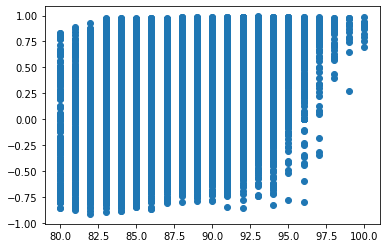

In [ ]:
plt.scatter(df['points'], df['compound'])
plt.show()

###Sentiment analysis (CoreNLP) - incomplete

In [ ]:
corenlp_dir = './corenlp'
stanza.install_corenlp(dir=corenlp_dir)

os.environ["CORENLP_HOME"] = corenlp_dir

2021-10-21 03:41:36 INFO: Installing CoreNLP package into ./corenlp...


2021-10-21 03:41:51 WARNING: For customized installation location, please set the `CORENLP_HOME` environment variable to the location of the installation. In Unix, this is done with `export CORENLP_HOME=./corenlp`.


In [ ]:
!ls $CORENLLP_HOME

corenlp  gdrive  sample_data


In [ ]:
# Construct a CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9001
client = CoreNLPClient(
    annotators=['tokenize','ssplit', 'pos', 'lemma', 'ner'], 
    memory='4G', 
    endpoint='http://localhost:9001',
    be_quiet=True)
print(client)

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
time.sleep(10)

2021-10-19 06:00:13 INFO: Writing properties to tmp file: corenlp_server-d7ad50292e9841c1.props
2021-10-19 06:00:13 INFO: Starting server with command: java -Xmx4G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-d7ad50292e9841c1.props -annotators tokenize,ssplit,pos,lemma,ner -preload -outputFormat serialized


In [ ]:
stanza.download('en')

2021-10-21 03:41:52 INFO: Downloading default packages for language: en (English)...


2021-10-21 03:42:08 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
df.description

0        Tart and snappy, the flavors of lime flesh and...
1        Pineapple rind, lemon pith and orange blossom ...
2        Much like the regular bottling from 2012, this...
3        Blackberry and raspberry aromas show a typical...
4        Here's a bright, informal red that opens with ...
                               ...                        
70652    While it's rich, this beautiful dry wine also ...
70653    Citation is given as much as a decade of bottl...
70654    Well-drained gravel soil gives this wine its c...
70655    A dry style of Pinot Gris, this is crisp with ...
70656    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 70657, dtype: object

In [ ]:
# Add empty column columns
header_list_new = ['numSentence', 'numWords', 'totSentiment', 'avgSentiment', 'Sfreq0','Sfreq1','Sfreq2','Sfreq3','Sfreq4','Sfreq5']
for i, name in enumerate(header_list_new):
    df[name] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from pycorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost:9001')

def stanford_sentiment(text_str):
    res = nlp.annotate(text_str,
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json',
                       'timeout': 30000,
                   })
    numSentence = len(res["sentences"])
    numWords = len(text_str.split())
    
    arraySentVal = np.zeros(numSentence)

    for i, s in enumerate(res["sentences"]):
        arraySentVal[i] = int(s["sentimentValue"])

    totSentiment = sum(arraySentVal)

    avgSentiment = np.mean(arraySentVal)

#1 : Negative, 2 : Neutral, 3 : Positive
    bins = [0,1,2,3,4,5,6]
    freq = np.histogram(arraySentVal, bins)[0]    

    return(numSentence, numWords, totSentiment, avgSentiment, freq)

In [ ]:
dfLength = len(df)

for i in range(0,1000):
    try:
        numSentence, numWords, totSentiment, avgSentiment, freq = stanford_sentiment(df.description[i])
        df.loc[i,'numSentence'] = numSentence
        df.loc[i,'numWords'] = numWords
        df.loc[i,'totSentiment'] = totSentiment
        df.loc[i,'avgSentiment'] = avgSentiment
        df.loc[i,'Sfreq0'] = freq[0]
        df.loc[i,'Sfreq1'] = freq[1]
        df.loc[i,'Sfreq2'] = freq[2]
        df.loc[i,'Sfreq3'] = freq[3]
        df.loc[i,'Sfreq4'] = freq[4]
        df.loc[i,'Sfreq5'] = freq[5]
    except:
        print("error where i =", i)

error where i = 0
error where i = 1
error where i = 2
error where i = 3
error where i = 4
error where i = 5
error where i = 6
error where i = 7
error where i = 8
error where i = 9
error where i = 10
error where i = 11
error where i = 12
error where i = 13
error where i = 14
error where i = 15
error where i = 16
error where i = 17
error where i = 18
error where i = 19
error where i = 20
error where i = 21
error where i = 22
error where i = 23
error where i = 24
error where i = 25
error where i = 26
error where i = 27
error where i = 28
error where i = 29
error where i = 30
error where i = 31
error where i = 32
error where i = 33
error where i = 34
error where i = 35
error where i = 36
error where i = 37
error where i = 38
error where i = 39
error where i = 40
error where i = 41
error where i = 42
error where i = 43
error where i = 44
error where i = 45
error where i = 46
error where i = 47
error where i = 48
error where i = 49
error where i = 50
error where i = 51
error where i = 52
err

In [ ]:
# Shut down the background CoreNLP server
#client.stop()

time.sleep(10)
!ps -o pid,cmd | grep java

   2183 /bin/bash -c ps -o pid,cmd | grep java
   2185 grep java


##가설 2. 가격이 높을수록 평점이 좋을 것 이다.

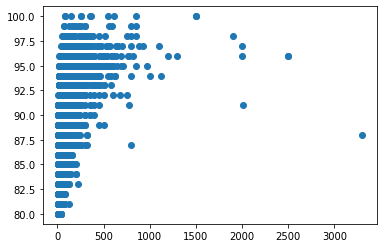

In [ ]:
plt.scatter(df['price'], df['points'])
plt.show()

대체적으로 가격이 높을수록 평점이 좋은것으로 보인다.

##가설 3. 가격이 높을수록 긍정적인 리뷰 일 것이다.

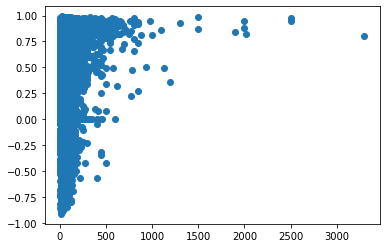

In [ ]:
plt.scatter(df['price'], df['compound'])
plt.show()

평점의 경우 다소 고루 분포되어 있는것을 볼 수 있었지만, 감정분석을 한 결과 가격이 오를수록 확실히 좋은 반응을 보이는것을 알 수 있다.

##가설 4. 와인의 고장인 프랑스가 평균이 가장 높을것이다.

In [ ]:
pip install pycountry

In [ ]:
def do_fuzzy_search(country):
    result = pycountry.countries.search_fuzzy(country)
    return result[0].alpha_3
iso_map = {country: do_fuzzy_search(country) for country in df["country"].unique()}
df["country_code"] = df["country"].map(iso_map)
grouped = df.groupby(['country_code','country'])
avg=pd.DataFrame(grouped['points'].agg(np.mean))
avg.reset_index(inplace=True)
avg.columns=['Country Code','Country','Average Points']
fig = px.choropleth(avg, locations=avg['Country Code'],color=avg['Average Points'],hover_name=avg['Country'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#Recommend model

##content based recommendation

In [ ]:
df['len']=df['description'].apply(lambda x:len(x.split(' ')))
winedf=df[df['len']>=50]
winedf.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(14312, 24)

In [ ]:
sp.prefer_gpu()
nlp = en_core_web_sm.load()
def clean_text(doc):
    #Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    doc = nlp(doc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 
winedf['cleaned_description']=winedf.apply(lambda row: clean_text(row["description"]) ,axis=1)
winedf.reset_index(inplace=True)
winedf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,country,description,points,price,province,region_1,taster_name,title,variety,winery,scores,compound,numSentence,numWords,totSentiment,avgSentiment,Sfreq0,Sfreq1,Sfreq2,Sfreq3,Sfreq4,Sfreq5,country_code,len,cleaned_description
0,14,US,"Red fruit aromas pervade on the nose, with cig...",87,32.0,Virginia,Virginia,Alexander Peartree,Quiévremont 2012 Meritage (Virginia),Meritage,Quiévremont,"{'neg': 0.058, 'neu': 0.82, 'pos': 0.121, 'com...",0.6124,0,0,0,0,0,0,0,0,0,0,USA,55,red fruit aroma pervade nose cigar box menthol...
1,24,US,Clarksburg is becoming a haven for Chenin Blan...,86,16.0,California,Clarksburg,Virginie Boone,Clarksburg Wine Company 2010 Chenin Blanc (Cla...,Chenin Blanc,Clarksburg Wine Company,"{'neg': 0.0, 'neu': 0.866, 'pos': 0.134, 'comp...",0.7964,0,0,0,0,0,0,0,0,0,0,USA,50,clarksburg haven chenin blanc california bottl...
2,50,Spain,"Bland, mature aromas of white fruits are on th...",86,16.0,Galicia,Rías Baixas,Michael Schachner,Spyro 2014 Albariño (Rías Baixas),Albariño,Spyro,"{'neg': 0.091, 'neu': 0.803, 'pos': 0.106, 'co...",0.2263,0,0,0,0,0,0,0,0,0,0,ESP,52,bland mature aroma white fruit weak albariño f...
3,64,US,A wisp of bramble extends a savory tone from n...,88,20.0,New York,Finger Lakes,Anna Lee C. Iijima,Heron Hill 2015 Ingle Vineyard Riesling (Finge...,Riesling,Heron Hill,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",0.6597,0,0,0,0,0,0,0,0,0,0,USA,53,wisp bramble extend savory tone nose finish br...
4,74,US,"Lots of spearmint, coyote mint, hot licorice, ...",87,26.0,California,Santa Clara Valley,Matt Kettmann,Martin Ranch 2014 J.D. Hurley Zinfandel (Santa...,Zinfandel,Martin Ranch,"{'neg': 0.0, 'neu': 0.942, 'pos': 0.058, 'comp...",0.4588,0,0,0,0,0,0,0,0,0,0,USA,53,lot spearmint coyote mint hot licorice ginger ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14307,70637,Argentina,Compared to the regular 2006 Malbec from Chaka...,91,25.0,Mendoza Province,Luján de Cuyo,Michael Schachner,Chakana 2006 Reserve Malbec (Luján de Cuyo),Malbec,Chakana,"{'neg': 0.075, 'neu': 0.785, 'pos': 0.141, 'co...",0.6486,0,0,0,0,0,0,0,0,0,0,ARG,58,compare regular malbec chakana wine step weigh...
14308,70641,US,Hailing from one of the more popular vineyards...,90,20.0,California,Santa Ynez Valley,Matt Kettmann,Birichino 2013 Jurassic Park Vineyard Old Vine...,Chenin Blanc,Birichino,"{'neg': 0.091, 'neu': 0.879, 'pos': 0.03, 'com...",-0.6327,0,0,0,0,0,0,0,0,0,0,USA,66,hail popular vineyard varietal central coast w...
14309,70644,US,There's no bones about the use of oak in this ...,90,35.0,California,Napa Valley,Virginie Boone,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs,"{'neg': 0.04, 'neu': 0.844, 'pos': 0.116, 'com...",0.6249,0,0,0,0,0,0,0,0,0,0,USA,50,bone use oak wine spend month enjoy cradle eff...
14310,70648,Spain,Lightly baked berry aromas vie for attention w...,90,17.0,Northern Spain,Rioja,Michael Schachner,Viñedos Real Rubio 2010 Crianza (Rioja),Tempranillo Blend,Viñedos Real Rubio,"{'neg': 0.024, 'neu': 0.812, 'pos': 0.163, 'co...",0.8553,0,0,0,0,0,0,0,0,0,0,ESP,62,lightly bake berry aroma vie attention leather...


In [ ]:
le = preprocessing.LabelEncoder()
winedf['title_id']=le.fit_transform(winedf['title'])
contentdf=winedf[['title_id','title','description','cleaned_description']]
contentdf=contentdf.set_index('title_id')
contentdf.reset_index(inplace=True)
contentdf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title_id,title,description,cleaned_description
0,10774,Quiévremont 2012 Meritage (Virginia),"Red fruit aromas pervade on the nose, with cig...",red fruit aroma pervade nose cigar box menthol...
1,3531,Clarksburg Wine Company 2010 Chenin Blanc (Cla...,Clarksburg is becoming a haven for Chenin Blan...,clarksburg haven chenin blanc california bottl...
2,12154,Spyro 2014 Albariño (Rías Baixas),"Bland, mature aromas of white fruits are on th...",bland mature aroma white fruit weak albariño f...
3,6768,Heron Hill 2015 Ingle Vineyard Riesling (Finge...,A wisp of bramble extends a savory tone from n...,wisp bramble extend savory tone nose finish br...
4,8973,Martin Ranch 2014 J.D. Hurley Zinfandel (Santa...,"Lots of spearmint, coyote mint, hot licorice, ...",lot spearmint coyote mint hot licorice ginger ...
...,...,...,...,...
14307,2610,Chakana 2006 Reserve Malbec (Luján de Cuyo),Compared to the regular 2006 Malbec from Chaka...,compare regular malbec chakana wine step weigh...
14308,1337,Birichino 2013 Jurassic Park Vineyard Old Vine...,Hailing from one of the more popular vineyards...,hail popular vineyard varietal central coast w...
14309,5854,Flora Springs 2013 Barrel Fermented Chardonnay...,There's no bones about the use of oak in this ...,bone use oak wine spend month enjoy cradle eff...
14310,13650,Viñedos Real Rubio 2010 Crianza (Rioja),Lightly baked berry aromas vie for attention w...,lightly bake berry aroma vie attention leather...


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 3), stop_words='english')
tfidf_description = tfidf.fit_transform((contentdf["cleaned_description"])) 
cos_sim = linear_kernel(tfidf_description, tfidf_description) 

In [ ]:
indices = pd.Series(contentdf.index) 
def recommendations(title, cosine_sim = cos_sim): 
    recommended_wine = [] 
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False) 
    top_10_wines = list(similarity_scores.iloc[1:11].index)
    for i in top_10_wines: 
        recommended_wine.append(list(contentdf.index)[i]) 
    top_5_wines=[]
    for i in recommended_wine:
        if i not in top_5_wines and i!=title:
            top_5_wines.append(i)
    recommendwine=[]
    for i in top_5_wines:
        recommendwine.append(contentdf['title'][i])
    return recommendwine

In [ ]:
wine="La Bioca 2013  Barbaresco"
print("선택한 와인: ",wine)
a=contentdf.loc[contentdf['title']==wine]
id=a.index[0]
r=recommendations(id)
print("*****와인 추천 목록*****")
for i,j in zip(r,range(1,len(r)+1)):
    print(j,")",i)

선택한 와인:  La Bioca 2013  Barbaresco
*****와인 추천 목록*****
1 ) Aia Vecchia 2012 Lagone Red (Toscana)
2 ) Bruno Rocca 2012 Coparossa  (Barbaresco)
3 ) Firriato 2012 Ribeca Perricone (Terre Siciliane)
4 ) Mamete Prevostini 2012 Albareda  (Sforzato di Valtellina)
5 ) Fanti 2011  Brunello di Montalcino
6 ) Gianni Gagliardo 2009 Preve Riserva  (Barolo)
7 ) Mazzei 2012 Siepi Red (Toscana)
8 ) La Fusina 2013  Barolo
9 ) La Spinetta 2013 Valeirano  (Barbaresco)
10 ) Rainoldi 2010 Inferno Riserva  (Valtellina Superiore)


##collabrative filter recommendations


In [ ]:
grouped = df.groupby('taster_name')
list_1=[]
list_2=[]
for name,group in grouped:
    list_1.append(name)
    a=group['points']
    list_2.append(len(a))
data=pd.DataFrame(list_1,list_2)
data.reset_index(inplace=True)
data.columns=['count','name']
a=data.sort_values(['count'])
a

,count,name
4,6,Christina Pickard
5,16,Fiona Adams
3,128,Carrie Dykes
15,233,Susan Kostrzewa
0,369,Alexander Peartree
9,566,Lauren Buzzeo
2,1226,Anne Krebiehl MW
1,2207,Anna Lee C. Iijima
7,3105,Joe Czerwinski
6,3755,Jim Gordon


In [ ]:
index=df.loc[df['taster_name']=='Christina Pickard']
df.drop(index.index,inplace=True)
df.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,description,points,price,province,region_1,taster_name,title,variety,winery,scores,compound,numSentence,numWords,totSentiment,avgSentiment,Sfreq0,Sfreq1,Sfreq2,Sfreq3,Sfreq4,Sfreq5,country_code,len
0,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"{'neg': 0.053, 'neu': 0.947, 'pos': 0.0, 'comp...",-0.1280,0,0,0,0,0,0,0,0,0,0,USA,28
1,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"{'neg': 0.0, 'neu': 0.926, 'pos': 0.074, 'comp...",0.3400,0,0,0,0,0,0,0,0,0,0,USA,33
2,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...",0.8176,0,0,0,0,0,0,0,0,0,0,USA,41
3,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"{'neg': 0.0, 'neu': 0.96, 'pos': 0.04, 'compou...",0.1655,0,0,0,0,0,0,0,0,0,0,ESP,42
4,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",0.6369,0,0,0,0,0,0,0,0,0,0,ITA,31


In [ ]:
le = preprocessing.LabelEncoder()
df['taster_id']=le.fit_transform(df['taster_name'])
df['title_id']=le.fit_transform(df['title'])
cdf=df[['taster_id','title_id','taster_name','country','province','region_1','price','title','variety','winery','points']]
cdf.reset_index(inplace=True)
cdf.drop(['index'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [ ]:
cdf.head(5)

,taster_id,title_id,taster_name,country,province,region_1,price,title,variety,winery,points
0,11,53648,Paul Gregutt,US,Oregon,Willamette Valley,14.0,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,87
1,0,59860,Alexander Peartree,US,Michigan,Lake Michigan Shore,13.0,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,87
2,11,60790,Paul Gregutt,US,Oregon,Willamette Valley,65.0,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,87
3,10,61264,Michael Schachner,Spain,Northern Spain,Navarra,15.0,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,87
4,7,62365,Kerin O’Keefe,Italy,Sicily & Sardinia,Vittoria,16.0,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,87


In [ ]:
reader = Reader(rating_scale=(80, 100))
data = Dataset.load_from_df(cdf[['taster_id', 'title_id', 'points']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.8521  2.8478  2.8668  2.8550  2.8429  2.8529  0.0081  
MAE (testset)     2.3160  2.3176  2.3262  2.3213  2.3088  2.3180  0.0058  
Fit time          4.04    3.98    4.00    3.97    4.01    4.00    0.02    
Test time         0.09    0.09    0.10    0.09    0.09    0.09    0.00    


{'fit_time': (4.0366291999816895,
  3.9838356971740723,
  4.003920555114746,
  3.9650864601135254,
  4.008944749832153),
 'test_mae': array([2.31599983, 2.31757156, 2.32621359, 2.32127948, 2.3087834 ]),
 'test_rmse': array([2.85210227, 2.84781213, 2.86680757, 2.85501096, 2.8428557 ]),
 'test_time': (0.09294509887695312,
  0.09006094932556152,
  0.1028745174407959,
  0.08895611763000488,
  0.09457254409790039)}

In [ ]:
cdf.loc[cdf['taster_name']=='Fiona Adams']

,taster_id,title_id,taster_name,country,province,region_1,price,title,variety,winery,points
11480,4,62772,Fiona Adams,US,Colorado,Grand Valley,25.0,The Infinite Monkey Theorem 2015 Malbec (Grand...,Malbec,The Infinite Monkey Theorem,85
12063,4,60759,Fiona Adams,US,Colorado,Colorado,30.0,Sutcliffe 2014 Merlot (Colorado),Merlot,Sutcliffe,87
17024,4,38001,Fiona Adams,US,Colorado,Grand Valley,17.0,Kingman 2013 Cabernet Sauvignon (Grand Valley),Cabernet Sauvignon,Kingman,88
17697,4,20226,Fiona Adams,US,Colorado,Colorado,35.0,Creekside Cellars 2014 Cabernet Sauvignon (Col...,Cabernet Sauvignon,Creekside Cellars,87
18254,4,60758,Fiona Adams,US,Colorado,Colorado,28.0,Sutcliffe 2014 Cabernet Franc (Colorado),Cabernet Franc,Sutcliffe,89
18381,4,20227,Fiona Adams,US,Colorado,Grand Valley,45.0,Creekside Cellars 2014 Colorado's Cabernet Fra...,Cabernet Franc,Creekside Cellars,91
41766,4,41608,Fiona Adams,US,Texas,Texas,35.0,Llano Estacado 2014 Viviano Cabernet Sauvignon...,Cabernet Sauvignon-Sangiovese,Llano Estacado,89
53850,4,4930,Fiona Adams,US,Texas,Texas High Plains,40.0,Becker 2014 Chevaux Noir Cabernet Franc-Merlot...,Cabernet Franc-Merlot,Becker,88
54956,4,46105,Fiona Adams,US,Texas,Texas High Plains,30.0,Messina Hof 2015 Private Reserve Double Barrel...,Malbec,Messina Hof,88
59331,4,4928,Fiona Adams,US,Texas,Texas,25.0,Becker 2012 Reserve Cabernet Sauvignon (Texas),Cabernet Sauvignon,Becker,86


In [ ]:
def user_rec(id):
    taster= df[['title_id','country','province','region_1','price','title','variety','winery']].copy()
    taster = taster.reset_index()
# getting full dataset
    data = Dataset.load_from_df(cdf[['taster_id', 'title_id', 'points']], reader)
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    taster['Estimate_Score'] = taster['title_id'].apply(lambda x: svd.predict(id, x).est)
    taster = taster.drop(['index','title_id'], axis = 1)
    taster= taster.sort_values('Estimate_Score', ascending=False)
    return taster.head(10)

In [ ]:
name='Fiona Adams'
print("THE NAME OF THE TASTER: ",name)
details=cdf.loc[cdf['taster_name']==name]
id=details['taster_id'].iloc[0]
a=user_rec(id)
a.reset_index(inplace=True)
a.drop(['index'],axis=1,inplace=True)
details.reset_index(inplace=True)
details.drop(['index','taster_id','title_id','taster_name'],axis=1,inplace=True)
print(f"\n{name} 평가한 와인 목록")
display(details)
print(f"\n{name} 평가한 와인들과 비슷한 추천목록")
display(a)

THE NAME OF THE TASTER:  Fiona Adams

Fiona Adams 평가한 와인 목록


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,province,region_1,price,title,variety,winery,points
0,US,Colorado,Grand Valley,25.0,The Infinite Monkey Theorem 2015 Malbec (Grand...,Malbec,The Infinite Monkey Theorem,85
1,US,Colorado,Colorado,30.0,Sutcliffe 2014 Merlot (Colorado),Merlot,Sutcliffe,87
2,US,Colorado,Grand Valley,17.0,Kingman 2013 Cabernet Sauvignon (Grand Valley),Cabernet Sauvignon,Kingman,88
3,US,Colorado,Colorado,35.0,Creekside Cellars 2014 Cabernet Sauvignon (Col...,Cabernet Sauvignon,Creekside Cellars,87
4,US,Colorado,Colorado,28.0,Sutcliffe 2014 Cabernet Franc (Colorado),Cabernet Franc,Sutcliffe,89
5,US,Colorado,Grand Valley,45.0,Creekside Cellars 2014 Colorado's Cabernet Fra...,Cabernet Franc,Creekside Cellars,91
6,US,Texas,Texas,35.0,Llano Estacado 2014 Viviano Cabernet Sauvignon...,Cabernet Sauvignon-Sangiovese,Llano Estacado,89
7,US,Texas,Texas High Plains,40.0,Becker 2014 Chevaux Noir Cabernet Franc-Merlot...,Cabernet Franc-Merlot,Becker,88
8,US,Texas,Texas High Plains,30.0,Messina Hof 2015 Private Reserve Double Barrel...,Malbec,Messina Hof,88
9,US,Texas,Texas,25.0,Becker 2012 Reserve Cabernet Sauvignon (Texas),Cabernet Sauvignon,Becker,86



Fiona Adams 평가한 와인들과 비슷한 추천목록


,country,province,region_1,price,title,variety,winery,Estimate_Score
0,US,Colorado,Grand Valley,45.0,Creekside Cellars 2014 Colorado's Cabernet Fra...,Cabernet Franc,Creekside Cellars,88.557613
1,Australia,South Australia,South Australia,850.0,Penfolds 2008 Grange Shiraz (South Australia),Shiraz,Penfolds,88.478612
2,Australia,South Australia,Barossa Valley,95.0,Standish 2012 Andelmonde Shiraz (Barossa Valley),Shiraz,Standish,88.469139
3,Italy,Tuscany,Brunello di Montalcino,550.0,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi,88.457282
4,Australia,South Australia,Barossa Valley,125.0,Torbreck 2013 The Factor Shiraz (Barossa Valley),Shiraz,Torbreck,88.455979
5,US,California,El Dorado,35.0,Donkey & Goat 2010 Fenaughty Vineyard Syrah (E...,Syrah,Donkey & Goat,88.416098
6,Italy,Lombardy,Valtellina Superiore,105.0,Arpepe 2007 Sassella Vigna Regina Riserva (Va...,Nebbiolo,Arpepe,88.365120
7,Australia,Victoria,Rutherglen,300.0,Chambers Rosewood Vineyards NV Rare Muscadelle...,Muscadelle,Chambers Rosewood Vineyards,88.358000
8,Australia,Victoria,Rutherglen,350.0,Chambers Rosewood Vineyards NV Rare Muscadelle...,Muscadelle,Chambers Rosewood Vineyards,88.358000
9,France,Rhône Valley,Châteauneuf-du-Pape,169.0,Château La Nerthe 2012 Clos de Beauvenir White...,Rhône-style White Blend,Château La Nerthe,88.357422


##popularity based recommendation


In [ ]:
grouped = df.groupby('title')
popular_wine = pd.DataFrame(grouped['points'].agg([np.size, np.mean]))
most_popular = popular_wine.sort_values(['size'], ascending=False)
most_popular.head(10)
pop_title=list(most_popular[:11].index)
print("*****와인 추천 목록*****")
for i,j in zip(pop_title,range(1,len(pop_title)+1)):
    print(j,')',i)

*****와인 추천 목록*****
1 ) Segura Viudas NV Extra Dry Sparkling (Cava)
2 ) Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)
3 ) Bailly-Lapierre NV Brut  (Crémant de Bourgogne)
4 ) Ruinart NV Brut Rosé  (Champagne)
5 ) Segura Viudas NV Reserva Heredad Sparkling (Cava)
6 ) Freixenet NV Cordon Negro Extra Dry Sparkling (Cava)
7 ) Domaine Charles Baur NV Brut Sparkling (Crémant d'Alsace)
8 ) Freixenet NV Carta Nevada Brut Sparkling (Cava)
9 ) Freixenet NV Cordon Negro Brut Sparkling (Cava)
10 ) Taittinger NV Nocturne Sec  (Champagne)
11 ) Segura Viudas NV Brut Reserva Sparkling (Cava)
